In [34]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
import os
working_dir = os.path.expanduser('~/workspace/theislab/mubind/docs/notebooks/scatac')
if os.path.exists(working_dir):
    os.chdir(working_dir)

In [36]:
import mubind as mb
import numpy as np
import pandas as pd
import torch
import bindome as bd
bd.constants.ANNOTATIONS_DIRECTORY = '../../../annotations'
# mb.models.MultiBind
import torch.optim as topti
import torch.utils.data as tdata
import matplotlib.pyplot as plt
import logomaker
import os
import scipy
import pickle

# Use a GPU if available, as it should be faster.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

Using device: cuda:0


In [37]:
import scanpy as sc

In [38]:
# create a backup with neighbors+umap included
atac_datadir = '../../../../atac_poisson_study/data'
adata_updated_path = os.path.join(atac_datadir, '10k_pbmc_ATACv2_nextgem_Chromium_Controller_filtered_peak_bc_matrix_with_umap.h5ad')
if not os.path.exists(adata_updated_path):
    adata = mb.bindome.datasets.scATAC.PBMCs_10x_v2(datadir=atac_datadir)
    peak_ids = adata.var_names
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)
    adata.write(adata_updated_path, compression='lzf')
adata = sc.read_h5ad(adata_updated_path)


In [39]:
adata.layers['counts'] = adata.X

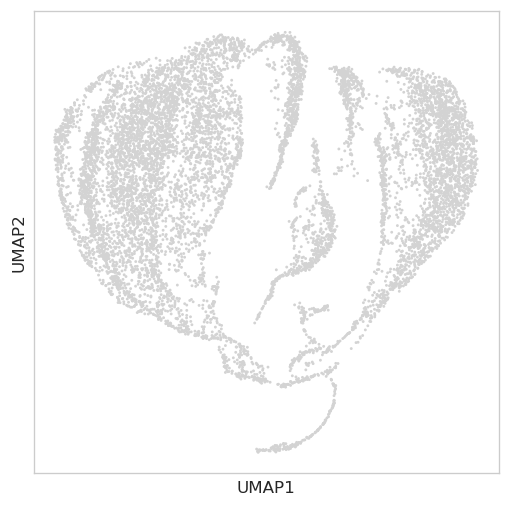

In [40]:
mb.pl.set_rcParams({'figure.figsize': [5, 5], 'figure.dpi': 120})
sc.pl.umap(adata)

In [60]:
ad = mb.pp.sample_anndata(adata, n_sample_obs=adata.shape[0], n_sample_var=adata.shape[1])
ad.shape

(10246, 165434)

### This extension is needed to make peaks homogeneous, and avoid long peaks

In [61]:
ad.var

,gene_ids,feature_types,genome,chr,start,end,peak.length
chr1:9772-10660,chr1:9772-10660,Peaks,GRCh38,chr1,9772,10660,889
chr1:180712-181178,chr1:180712-181178,Peaks,GRCh38,chr1,180712,181178,467
chr1:181200-181607,chr1:181200-181607,Peaks,GRCh38,chr1,181200,181607,408
chr1:191183-192084,chr1:191183-192084,Peaks,GRCh38,chr1,191183,192084,902
chr1:267576-268461,chr1:267576-268461,Peaks,GRCh38,chr1,267576,268461,886
...,...,...,...,...,...,...,...
KI270713.1:13054-13909,KI270713.1:13054-13909,Peaks,GRCh38,KI270713.1,13054,13909,856
KI270713.1:15212-15933,KI270713.1:15212-15933,Peaks,GRCh38,KI270713.1,15212,15933,722
KI270713.1:21459-22358,KI270713.1:21459-22358,Peaks,GRCh38,KI270713.1,21459,22358,900
KI270713.1:29676-30535,KI270713.1:29676-30535,Peaks,GRCh38,KI270713.1,29676,30535,860


In [62]:
extend = 50
ad.var['summit'] = ((ad.var['end'] + ad.var['start']) / 2).astype(int)
ad.var['summit.start'] = ad.var['summit'] - extend
ad.var['summit.end'] = ad.var['summit'] + extend
ad.var['k.summit'] = ad.var['chr'].astype(str) + ':' + ad.var['summit.start'].astype(str) + '-' + ad.var['summit.end'].astype(str)


### Get sequences from fasta files

In [63]:
n_seqs = max(len(ad.var_names), 750)# adata.shape[1] # None # 1000
seqs = mb.bindome.tl.get_sequences_from_bed(ad.var[['chr', 'summit.start', 'summit.end']].head(n_seqs), genome='hg38', uppercase=True)
keys = set([s[0] for s in seqs])
ad = ad[:,ad.var['k.summit'].isin(keys)]
# seqs = [[s[0], s[1].upper()] for s in seqs[0]]

/tmp/tmpkdm47i1u
genome hg38 False
options
/mnt/c/Users/ignacio.ibarra/Dropbox/annotations/hg38/genome/hg38.fa
True /mnt/c/Users/ignacio.ibarra/Dropbox/annotations/hg38/genome/hg38.fa
running bedtools...
bedtools getfasta -fi /mnt/c/Users/ignacio.ibarra/Dropbox/annotations/hg38/genome/hg38.fa -bed /tmp/tmpkdm47i1u -fo /tmp/tmp6zbte7wj


WARNING. chromosome (KI270727.1) was not found in the FASTA file. Skipping.
WARNING. chromosome (GL000194.1) was not found in the FASTA file. Skipping.
WARNING. chromosome (GL000194.1) was not found in the FASTA file. Skipping.
WARNING. chromosome (GL000194.1) was not found in the FASTA file. Skipping.
WARNING. chromosome (GL000194.1) was not found in the FASTA file. Skipping.
WARNING. chromosome (GL000194.1) was not found in the FASTA file. Skipping.
WARNING. chromosome (GL000205.2) was not found in the FASTA file. Skipping.
WARNING. chromosome (GL000205.2) was not found in the FASTA file. Skipping.
WARNING. chromosome (GL000205.2) was not found in the FASTA file. Skipping.
WARNING. chromosome (GL000205.2) was not found in the FASTA file. Skipping.
WARNING. chromosome (GL000205.2) was not found in the FASTA file. Skipping.
WARNING. chromosome (GL000205.2) was not found in the FASTA file. Skipping.
WARNING. chromosome (GL000205.2) was not found in the FASTA file. Skipping.
WARNING. chr

### Preparation of training data

In [ ]:
# use the raw counts across cells
next_data = pd.DataFrame(ad.X.T.A) # sparse.from_spmatrix(counts.A)
next_data['var'] = next_data.var(axis=1)
next_data.index = [s[1] for s in seqs]
next_data.index.name = 'seq'
print(next_data.shape)

In [ ]:


# selection of cells based on overall var score
n_cells = 1000
top_var = next_data[['var']].sort_values('var', ascending=False).index[:n_cells]
# next_data = next_data.head(10000)
next_data_sel = next_data.reindex(top_var) # .reset_index(drop=True)
next_data_sel
del next_data_sel['var']
# next_data_sel.index = next_data_sel['seq']
# del next_data_sel['seq']
df = next_data_sel.copy() # sample
print(next_data_sel.shape)


In [ ]:
# enr series = False indicates that everything is independent.
dataset = mb.datasets.SelexDataset(df, n_rounds=df.shape[1], enr_series=False)

In [ ]:
# df = next_data_sel.copy()
# dataset = mb.datasets.GenomicsDataset(df)
# train = tdata.DataLoader(dataset=dataset, batch_size=1000, shuffle=True)

train = tdata.DataLoader(dataset=dataset, batch_size=1024, shuffle=True)

In [ ]:
criterion = mb.tl.PoissonLoss()
n_kernels = 2
w = [20 for r in range(n_kernels)]
model = mb.models.Multibind.make_model(train, n_kernels, criterion, kernels=[0, 2] + w,
                                       # use_dinuc=True, dinuc_mode='full',
                                       optimize_sym_weight=False,
                                       optimize_exp_barrier=True,
                                       optimize_log_dynamic=False,
                                       use_dinuc=False,
                                       device=device,
                                       dinuc_mode=None).cuda()


### Include kNN into the model

In [ ]:
sc.pl.umap(ad)

In [ ]:
model.prepare_knn(ad)

In [ ]:
model = model.cuda()

In [ ]:
import torch.optim as topti


In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
model

In [ ]:
model, best_loss = model.optimize_iterative(train, n_epochs=[500, 200, 200, 200], show_logo=False, use_mono=True, use_dinuc=False, dinuc_mode='local',
                                            opt_kernel_shift=[0, 0, 1, 1],
                                            opt_kernel_length=[0, 0, 1, 1],
                                            shift_max=1, shift_step=1, optimiser=topti.Adam,
                                            # skip_kernels=range(2, 4),
                                            n_batches=1, n_rounds=df.shape[1], num_epochs_shift_factor=1, # log_etas=log_etas, # log_etas=log_etas,
                                            kernels = [0] + [2] + [20, 20], r2_per_epoch=True,
                                            early_stopping=50, log_each=10, w=25, max_w=25) #  target_dim=train.dataset.signal.shape[1])

In [ ]:
r2 = mb.tl.scores(model, train, by='batch')
print("R^2:", r2)


In [ ]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 20, 5
rcParams['figure.dpi'] = 100
mb.pl.conv(model, n_cols=2, show=True)
plt.show()


### Here we attempt to visualize the log_dynamic scores

In [ ]:
# contributions per newly added kernel
rcParams['figure.figsize'] = 2, 3
rcParams['figure.dpi'] = 80
import seaborn as sns
r2 = pd.DataFrame(model.best_r2_by_new_filter, columns=['r2']).reset_index()
sns.barplot(data=r2, x='index', y='r2')

In [ ]:
# dyn_score
dyn_score = mb.tl.dynamic_score(model)
dyn_score_scaled = (dyn_score - dyn_score.min()) / (dyn_score.max() - dyn_score.min())
ad.obs['dynamic_score'] = dyn_score_scaled

In [ ]:
ad.obs['dynamic_score_cluster'] = np.where(dyn_score_scaled > dyn_score_scaled.mean(), 'dynamic', 'static')
mu, sigma = dyn_score.mean(), dyn_score.std()
zscore = ((dyn_score - mu) / sigma)
z1 = np.where(zscore > 1, 'dynamic', 'static')
z2 = np.where(zscore > 2, 'dynamic', 'static')

ad.obs['dynamic_score_z1'] = z1
ad.obs['dynamic_score_z2'] = z2

#  ad.obs['dynamic_score_cluster'] = np.where(dynamic_score > .5, , 0)
sns.displot(dyn_score)
plt.xlabel('dynamic score (normalized)')


In [ ]:
sc.tl.umap(ad)

In [ ]:
# contributions per newly added kernel
rcParams['figure.figsize'] = 5, 5
rcParams['figure.dpi'] = 120
sc.pl.umap(ad, color=['dynamic_score'], cmap='RdBu_r', sort_order=True)
sc.pl.umap(ad, color=['dynamic_score_z1'], cmap='RdBu_r', sort_order=True)


In [ ]:
sc.tl.embedding_density(ad, basis='umap', groupby='dynamic_score_z1')
sc.tl.embedding_density(ad, basis='umap', groupby='dynamic_score_z2')

In [ ]:
sc.pl.embedding_density?

In [ ]:
mb.pl.set_rcParams({'figure.figsize': [5, 5], 'figure.dpi': 90})
sc.pl.embedding_density(ad, basis='umap', key='umap_density_dynamic_score_z1', group=['dynamic', 'static'], color_map='Reds') # basis='umap', groupby='dynamic_score_cluster')
sc.pl.embedding_density(ad, basis='umap', key='umap_density_dynamic_score_z1', group=['dynamic', 'static'], color_map='Blues') # basis='umap', groupby='dynamic_score_cluster')
# sc.pl.embedding_density(ad, basis='umap', key='umap_density_dynamic_score_z2', group='dynamic') # basis='umap', groupby='dynamic_score_cluster')

In [ ]:
mb.pl.set_rcParams({'figure.figsize': [5, 5], 'figure.dpi': 90})
mb.pl.kmer_enrichment(model, train, log_scale=False, style='scatter', ylab='t1', xlab='p1', k=8)

In [ ]:
mb.pl.set_rcParams({'figure.figsize': [15, 3], 'figure.dpi': 90})
mb.pl.conv(model, title=False, xticks=False, rowspan_dinuc=0, rowspan_mono=1, n_rows=5, n_cols=12) # n_cols=len(reduced_groups))


In [ ]:
import resource
print('total GB used:', resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1e6)
